In [1]:
# Install TensorFlow (if not already installed)
!pip install tensorflow


# **Data Preparation**

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Class names
class_names = ['Airplane','Automobile','Bird','Cat','Deer',
               'Dog','Frog','Horse','Ship','Truck']

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Training samples: 50000
Test samples: 10000


# **Data Augmentation**

In [3]:
#Data Augmentation:
#To improve model generalization, we'll apply data augmentation techniques such as rotation, shifting, and flipping.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)


# **Model Selection and Fine-Tuning**

## Loading the Pre-trained ResNet50 Model

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(32,32,3))

# Freeze the base model
base_model.trainable = False


#Adding Custom Layers:
#We'll add custom layers on top of the base model to adapt it to the CIFAR-10 classification task.

# Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Add the final softmax layer for 10 classes
predictions = Dense(10, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#Fine-Tuning the Model:
#After training the top layers, we'll unfreeze some layers of the base model for fine-tuning.

# Unfreeze the last few layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 140  # Example layer index

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 17,086,474 (65.18 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

# **Training the Model**

## Phase 1: Training the Top Layers

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-5)

# Train the top layers
history_top = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=x_train.shape[0] // 64,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.2424 - loss: 2.2852 - val_accuracy: 0.1712 - val_loss: 5.0724 - learning_rate: 1.0000e-04
Epoch 2/30
  1/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.3281 - loss: 1.8911

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3281 - loss: 1.8911 - val_accuracy: 0.1682 - val_loss: 5.1505 - learning_rate: 1.0000e-04
Epoch 3/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.3803 - loss: 1.7659 - val_accuracy: 0.2053 - val_loss: 3.5116 - learning_rate: 1.0000e-04
Epoch 4/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4062 - loss: 1.8185 - val_accuracy: 0.2139 - val_loss: 3.3708 - learning_rate: 1.0000e-04
Epoch 5/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.4211 - loss: 1.6352 - val_accuracy: 0.1889 - val_loss: 5.4780 - learning_rate: 1.0000e-04
Epoch 6/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4688 - loss: 1.5438 - val_accuracy: 0.1931 - val_loss: 5.3590 - learning_rate: 1.0000e-04
Epoch 7/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.4442 - loss: 1.5700 - val_accuracy: 0.2686 - val_loss: 2.5674 - learning_rate: 1.0000e-04
Epoch 8/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.515

## Phase 2: Fine-Tuning the Model

In [6]:
# Fine-tune the model
history_fine = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=x_train.shape[0] // 64,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5471 - loss: 1.2909 - val_accuracy: 0.5057 - val_loss: 1.4222 - learning_rate: 1.0000e-05
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4531 - loss: 1.3326 - val_accuracy: 0.5046 - val_loss: 1.4266 - learning_rate: 1.0000e-05
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5510 - loss: 1.2737 - val_accuracy: 0.5109 - val_loss: 1.4084 - learning_rate: 1.0000e-05
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5469 - loss: 1.3087 - val_accuracy: 0.5112 - val_loss: 1.4019 - learning_rate: 1.0000e-05
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.5611 - loss: 1.2610 - val_accuracy: 0.4474 - val_loss: 1.6388 - learning_rate: 1.0000e-05
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5781 - loss: 1.1928 - val_accuracy: 0.4477 - val_loss: 1.6381 - learning_rate: 1.0000e-05
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - ac

# **Evaluating the Model**

In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 - 2s - 7ms/step - accuracy: 0.5473 - loss: 1.3063
Test Accuracy: 54.73%


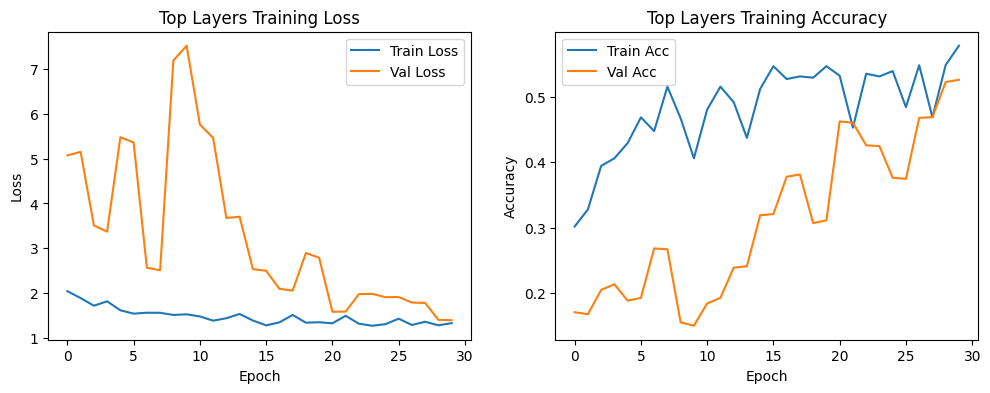

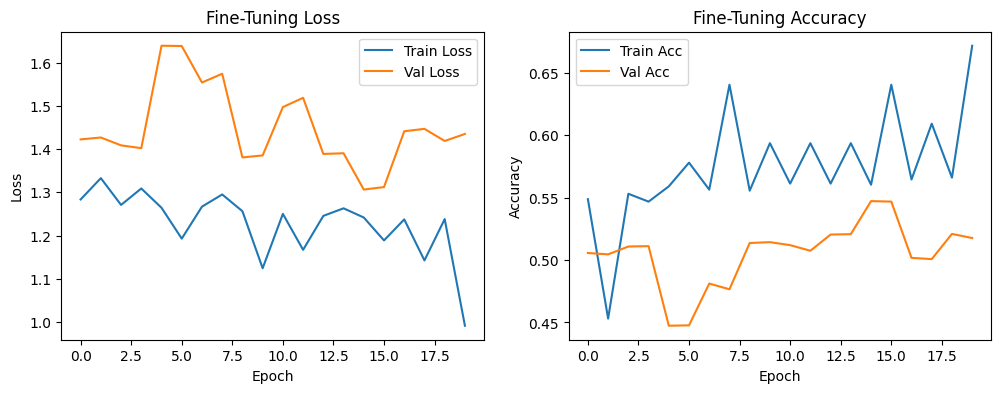

In [21]:
#Plotting Training History

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12,4))
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot training history
plot_history(history_top, "Top Layers Training")
plot_history(history_fine, "Fine-Tuning")


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step


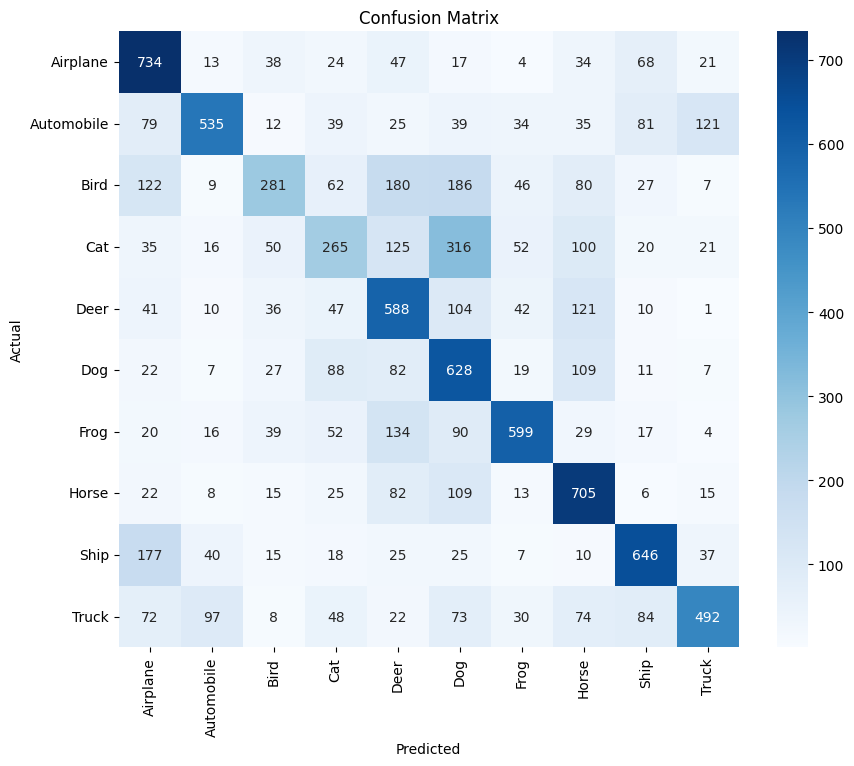

              precision    recall  f1-score   support

    Airplane       0.55      0.73      0.63      1000
  Automobile       0.71      0.54      0.61      1000
        Bird       0.54      0.28      0.37      1000
         Cat       0.40      0.27      0.32      1000
        Deer       0.45      0.59      0.51      1000
         Dog       0.40      0.63      0.49      1000
        Frog       0.71      0.60      0.65      1000
       Horse       0.54      0.70      0.61      1000
        Ship       0.67      0.65      0.66      1000
       Truck       0.68      0.49      0.57      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.54     10000
weighted avg       0.56      0.55      0.54     10000



In [22]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict classes
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


# **Feature Detection and Object Detection**

In [8]:
# Install OpenCV if not already installed
!pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/object.jpg.jpg'  # Replace with your image path
image = cv2.imread('/content/object.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Harris Corner Detection
gray_image = np.float32(gray_image)
dst = cv2.cornerHarris(gray_image, 2, 3, 0.04)

# Dilate the corner image to enhance corner points
dst = cv2.dilate(dst, None)

# Threshold to mark the corners
corners = dst > 0.01 * dst.max()
image[corners] = [0, 0, 255]

# Print the coordinates of the detected corners
coords = np.argwhere(corners)
print("Detected corners:")
for coord in coords:
    print(f"X: {coord[1]}, Y: {coord[0]}")

# Plot the results
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.axis('off')
plt.show()


Streaming output truncated to the last 5000 lines.
X: 224, Y: 175
X: 225, Y: 175
X: 226, Y: 175
X: 227, Y: 175
X: 228, Y: 175
X: 229, Y: 175
X: 235, Y: 175
X: 236, Y: 175
X: 237, Y: 175
X: 238, Y: 175
X: 246, Y: 175
X: 247, Y: 175
X: 248, Y: 175
X: 256, Y: 175
X: 257, Y: 175
X: 258, Y: 175
X: 259, Y: 175
X: 260, Y: 175
X: 204, Y: 176
X: 205, Y: 176
X: 206, Y: 176
X: 207, Y: 176
X: 208, Y: 176
X: 222, Y: 176
X: 223, Y: 176
X: 224, Y: 176
X: 225, Y: 176
X: 226, Y: 176
X: 227, Y: 176
X: 228, Y: 176
X: 229, Y: 176
X: 235, Y: 176
X: 236, Y: 176
X: 237, Y: 176
X: 238, Y: 176
X: 256, Y: 176
X: 257, Y: 176
X: 258, Y: 176
X: 259, Y: 176
X: 260, Y: 176
X: 204, Y: 177
X: 205, Y: 177
X: 206, Y: 177
X: 207, Y: 177
X: 208, Y: 177
X: 209, Y: 177
X: 224, Y: 177
X: 225, Y: 177
X: 226, Y: 177
X: 227, Y: 177
X: 228, Y: 177
X: 229, Y: 177
X: 235, Y: 177
X: 236, Y: 177
X: 237, Y: 177
X: 238, Y: 177
X: 239, Y: 177
X: 256, Y: 177
X: 257, Y: 177
X: 258, Y: 177
X: 259, Y: 177
X: 260, Y: 177
X: 205, Y: 178
X: 2

# **Object Detection**

In [10]:
# Install necessary packages
!pip install torch torchvision
!pip install matplotlib




In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load Faster R-CNN model pre-trained on COCO
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load and preprocess the image
image_path = '/content/object.jpg'  # Replace with your image path
image = Image.open('/content/object.jpg').convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor()
])

image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Perform object detection
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
pred_classes = predictions[0]['labels']
pred_boxes = predictions[0]['boxes']
pred_scores = predictions[0]['scores']

# Define COCO classes
coco_classes = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair dryer', 'toothbrush'
]

# Print details about detections
print("Detected objects:")
for p, box, label in zip(pred_scores, pred_boxes, pred_classes):
    if p > 0.5:  # Confidence threshold
        print(f"Class: {coco_classes[label.item()]}, Confidence: {p.item():.2f}, Bounding Box: {box.tolist()}")

# Visualize results
def show_results(pil_img, prob, boxes, labels):
    plt.figure(figsize=(12,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = plt.cm.jet(np.linspace(0, 1, 80))

    for p, (box, label) in zip(prob, zip(boxes, labels)):
        if p > 0.5:  # Confidence threshold
            box = [int(i) for i in box]
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=2, edgecolor=colors[label % 80], facecolor='none')
            ax.add_patch(rect)
            plt.text(box[0], box[1], f'{coco_classes[label]}: {p:.2f}', fontsize=10,
                     bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Show results
show_results(image, pred_scores, pred_boxes, pred_classes)


Detected objects:
Class: horse, Confidence: 1.00, Bounding Box: [130.31639099121094, 225.0630340576172, 318.98773193359375, 534.1467895507812]
Class: bicycle, Confidence: 0.98, Bounding Box: [164.00514221191406, 105.0199203491211, 570.2531127929688, 448.6534423828125]
Class: bicycle, Confidence: 0.82, Bounding Box: [127.9829330444336, 139.33438110351562, 277.3939514160156, 382.80499267578125]
Class: car, Confidence: 0.76, Bounding Box: [471.6439514160156, 79.22530364990234, 680.576904296875, 169.9888153076172]
Class: bicycle, Confidence: 0.60, Bounding Box: [129.28016662597656, 231.70408630371094, 218.70828247070312, 381.32415771484375]
Class: truck, Confidence: 0.54, Bounding Box: [467.36944580078125, 83.12669372558594, 678.8590698242188, 167.97837829589844]


# **Image Segmentation and Object Tracking**

In [15]:
# Install required packages
!pip install torch torchvision
!pip install matplotlib

import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load the Mask R-CNN model pre-trained on COCO
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load and preprocess the image
image_path = '/content/object.jpg'  # Replace with your image path
image = Image.open('/content/object.jpg').convert("RGB")

transform = T.Compose([
    T.ToTensor()
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Perform image segmentation
with torch.no_grad():
    predictions = model(image_tensor)

# Extract predictions
masks = predictions[0]['masks']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Define COCO classes
coco_classes = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet',
    'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair dryer', 'toothbrush'
]

# Visualize segmentation results
def show_segmentation(pil_img, masks, labels, scores):
    plt.figure(figsize=(12,8))
    plt.imshow(pil_img)
    ax = plt.gca()

    for mask, label, score in zip(masks, labels, scores):
        if score > 0.5:  # Confidence threshold
            mask = mask.squeeze().cpu().numpy()
            color = np.random.rand(3,)
            mask = mask > 0.5
            masked_image = np.zeros_like(pil_img, dtype=np.uint8)
            masked_image[mask] = np.array(color) * 255
            plt.imshow(masked_image, alpha=0.5)
            plt.text(10, 10, f'{coco_classes[label]}: {score:.2f}', fontsize=10,
                     bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Show results
show_segmentation(image, masks, labels, scores)


In [1]:
!pip install opencv-contrib-python-headless


In [2]:
import cv2
print(cv2.__version__)
print(dir(cv2.TrackerKCF_create))


4.10.0
['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__text_signature__']


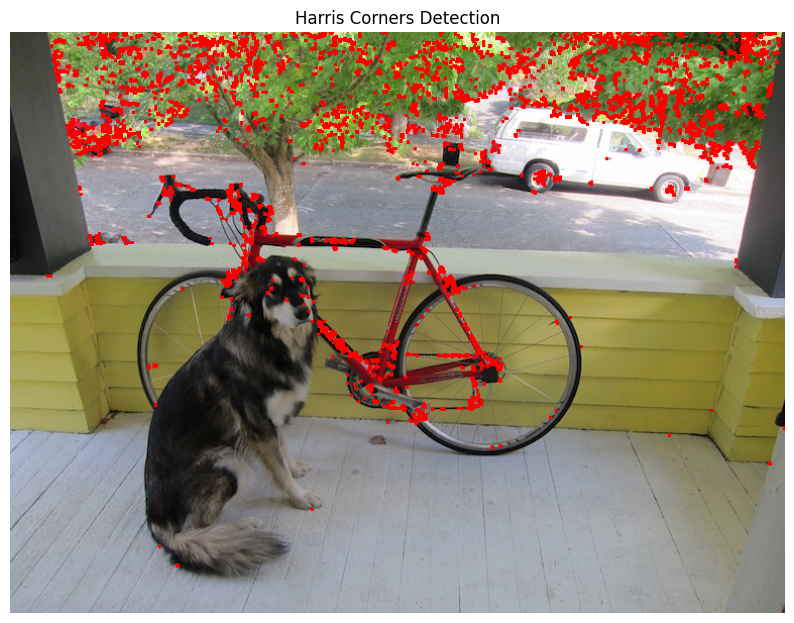

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/object.jpg'  # Replace with your image path
image = cv2.imread('/content/object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Harris Corner Detection
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)

# Threshold to identify the corners
image[dst > 0.01 * dst.max()] = [0, 0, 255]

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Harris Corners Detection')
plt.axis('off')
plt.show()


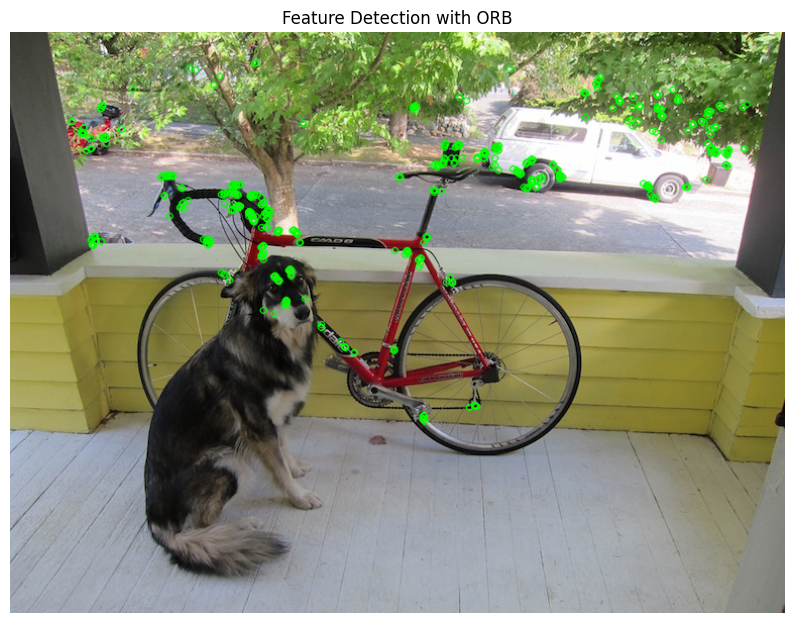

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image correctly
image_path = '/content/object.jpg'  # Replace with your correct image path
image = cv2.imread('/content/object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(gray, None)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Feature Detection with ORB')
plt.axis('off')
plt.show()


<ipython-input-15-9af02d678c1b>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_classes)


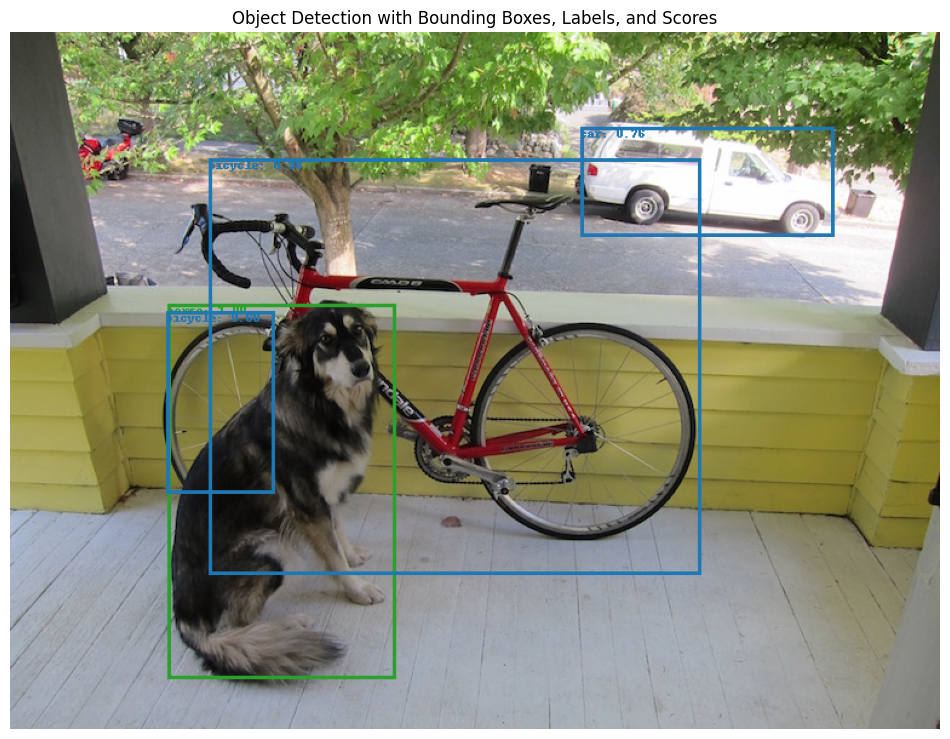

In [15]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from torchvision.ops import nms

# Load the image
image_path = '/content/object.jpg'  # Replace with your image path
image = Image.open('/content/object.jpg').convert("RGB")

# Define the transformations
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

# Preprocess the image
input_image = preprocess(image).unsqueeze(0)  # Add a batch dimension

# Load a pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Perform inference
with torch.no_grad():
    predictions = model(input_image)

def draw_boxes(predictions, image, threshold=0.5):
    draw = ImageDraw.Draw(image)
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Load COCO labels
    coco_labels = [
        'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
        'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
        'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
        'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
        'bed', 'dining table', 'toilet', 'TV', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
        'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair dryer',
        'toothbrush'
    ]

    # Generate a color for each label
    num_classes = len(coco_labels)
    colors = plt.cm.get_cmap('tab20', num_classes)

    # Load a larger font
    try:
        font = ImageFont.truetype("arial.ttf", 24)  # Adjust the size as needed
    except IOError:
        font = ImageFont.load_default()

    # Non-Maximum Suppression to remove overlapping boxes
    keep = nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold=0.3)

    for i in keep:
        box = boxes[i]
        label = labels[i]
        score = scores[i]

        if score > threshold:
            x_min, y_min, x_max, y_max = box
            color = colors(label / num_classes)[:3]  # Get a color for the class
            color = tuple(int(c * 255) for c in color)  # Convert from [0,1] to [0,255]

            # Draw bounding box
            draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=3)

            # Draw label with larger font
            text = f"{coco_labels[label]}: {score:.2f}"
            draw.text((x_min, y_min), text, fill=color, font=font)

    return image

# Draw the bounding boxes, labels, and scores on the image
image_with_boxes = draw_boxes(predictions, image)

# Visualize the result
plt.figure(figsize=(12, 12))
plt.imshow(image_with_boxes)
plt.title('Object Detection with Bounding Boxes, Labels, and Scores')
plt.axis('off')
plt.show()
